# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    df = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
    
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
df.query('last_price < 100000000')['last_price'].count()

23662

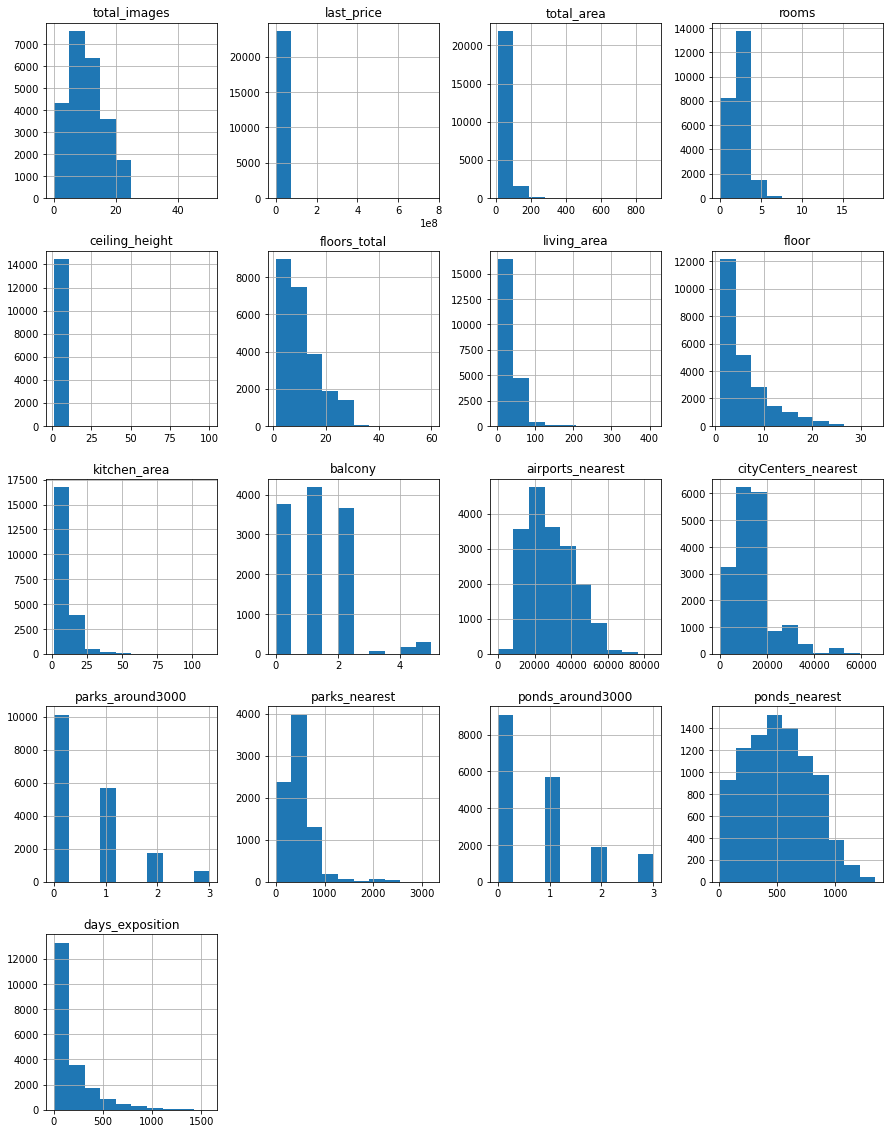

In [7]:
df.hist(figsize=(15, 20));

### Предобработка данных

In [8]:
df.isna().sum() # считаем количество пропущенных значений в каждом столбце

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [9]:
df.duplicated().sum() # проверяем количество явных дубликатов во всем датасете

0

Явных дубликатов не обнаружено.

In [10]:
# перевод в тип данных datetime
df['first_day_exposition'] = pd.to_datetime(
    df['first_day_exposition'],
    format='%Y-%m-%dT%H:%M:%S'
)

#### Балконы `balcony`

В столбце `balcony` пропущенные значения скорее всего являются `0`, т.е. балконов нет, поэтому заменим все пропуски на `0` и переведем в целочисленный формат.

In [11]:
df['balcony'] = df['balcony'].fillna(0).astype(int)

In [12]:
df['balcony'].sort_values().unique() # проверим остальные значения balcony

array([0, 1, 2, 3, 4, 5])

С уверенностью сказать, что 4 или 5 балконов - это ошибки, мы не можем, поэтому оставим эти данные как есть.

#### Названиях населенных пунктов `locality_name`

In [13]:
df['locality_name'].sort_values().unique() # проверяем все уникальные значения

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [14]:
# заполяем пропуски для неизвестных населенных пунктов строкой unknown
df['locality_name'] = df['locality_name'].fillna('unknown')

Видно, что есть неявные дубликаты в названиях:
* `поселок` и `посёлок`
* `посёлок городского типа` и `городской посёлок`
* `посёлок при железнодорожной станции` и `посёлок станции`
* `садоводческое некоммерческое товарищество` и `садовое товарищество`
* `деревня Кудрово` и `Кудрово` 
* `посёлок Мурино` и `Мурино`

Дубликаты `Кудрово` и `Мурино` появились скорее всего из-за того, что эти населенные пункты стали городами не так давно.

In [15]:
locality_names = {
    'поселок': 'посёлок',
    'посёлок городского типа': 'городской посёлок',
    'посёлок при железнодорожной станции': 'посёлок станции',
    'садоводческое некоммерческое товарищество': 'садовое товарищество',
    'деревня Кудрово': 'Кудрово',
    'посёлок Мурино': 'Мурино'
}

for key, value in locality_names.items(): # в цикле приводим все названия к одному виду
    df['locality_name'] = df['locality_name'].str.replace(key, value)

#### Высота потолков `ceiling_height`

In [16]:
df['ceiling_height'].sort_values().unique() # проверяем все значения высоты потолков

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

В значениях высоты полоков более 20 метров скорее всего ошиблись при написании, поэтому заменим их

In [17]:
df.loc[df['ceiling_height'] > 20, 'ceiling_height'] = \
df.loc[df['ceiling_height'] > 20, 'ceiling_height'] / 10

In [18]:
df[df['ceiling_height'] > 6] # проверим сколько и какие данные остались с потолками выше 6 м

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3474,3,1400000.0,30.0,2018-03-16,1,8.0,5.0,15.3,2,False,...,7.3,0,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0
5863,20,5650000.0,45.0,2018-08-15,1,8.3,16.0,19.3,14,NaN,...,8.3,1,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0
15061,19,5600000.0,56.4,2018-05-11,2,14.0,14.0,32.4,5,NaN,...,9.1,2,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
15743,14,5600000.0,67.0,2016-11-11,3,8.0,16.0,41.0,1,NaN,...,8.0,0,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0
17442,0,5350000.0,54.0,2015-06-16,2,8.0,5.0,29.0,2,NaN,...,NaN,1,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0
17496,15,6700000.0,92.9,2019-02-19,3,20.0,17.0,53.2,14,NaN,...,12.0,5,Санкт-Петербург,16295.0,15092.0,1.0,967.0,0.0,NaN,NaN
22309,20,5300000.0,45.0,2017-09-30,1,10.3,16.0,15.5,15,NaN,...,NaN,0,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0
22869,0,15000000.0,25.0,2018-07-25,1,10.0,5.0,14.0,5,True,...,11.0,5,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0


Осталось всего 8 строк с потолками выше 6 метров, скорее всего здесь тоже ошибки, поэтому пока заменим их на пустые значения. Также потолки ниже 2.2 метров кажутся неправдаподобными, поэтому их тоже пока заменим на пустые значения.

In [19]:
df.loc[(df['ceiling_height'] > 6) | (df['ceiling_height'] <= 2), 'ceiling_height'] = np.nan

In [20]:
df['ceiling_height'].isna().sum() # проверим сколько осталось пропущенных значений

9217

In [21]:
# проверим медианное значение высоты потолков в зависимости от населенного пункта
df.groupby('locality_name')['ceiling_height'].median().dropna().sort_values(ascending=False)

locality_name
Бокситогорск                    3.90
посёлок Ропша                   3.20
деревня Ваганово                3.15
деревня Глинка                  3.10
коттеджный посёлок Счастье      3.00
                                ... 
посёлок Войскорово              2.50
посёлок Возрождение             2.50
Тосно                           2.50
Светогорск                      2.50
городской посёлок Свирьстрой    2.45
Name: ceiling_height, Length: 251, dtype: float64

Медианное значение высоты потолков в городе Бокситогорск получилось довольно высоким, проверим почему так вышло.

In [22]:
df.query('locality_name == "Бокситогорск"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
638,6,980000.0,47.1,2019-04-12,2,NaN,3.0,29.0,3,NaN,...,9.0,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,4,950000.0,44.0,2018-05-05,2,NaN,5.0,NaN,2,NaN,...,6.0,1,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,156.0
1053,13,550000.0,29.0,2018-02-01,1,5.0,3.0,NaN,1,False,...,NaN,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0
1761,11,999000.0,62.0,2018-02-15,4,NaN,5.0,46.0,2,NaN,...,7.0,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,226.0
3010,6,850000.0,48.0,2016-03-11,2,NaN,5.0,NaN,5,NaN,...,NaN,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,174.0
3731,10,1310000.0,65.6,2019-02-22,3,NaN,5.0,42.0,4,NaN,...,7.5,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5821,7,820000.0,51.0,2017-12-09,2,NaN,5.0,32.0,5,NaN,...,8.5,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,130.0
8630,3,560000.0,32.0,2018-06-16,1,NaN,3.0,17.0,1,NaN,...,6.0,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,45.0
8767,6,650000.0,45.0,2017-06-24,2,NaN,5.0,30.0,1,NaN,...,6.0,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,68.0
8779,9,620000.0,36.0,2018-01-15,1,NaN,5.0,19.0,5,NaN,...,8.0,0,Бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,45.0


Всего 2 значения их 16 ненулевые, поэтому медиана получилась завышенной. Заменим пропущенные данные общим медианным значением.

In [23]:
df.loc[(df['locality_name'] == 'Бокситогорск') & (df['ceiling_height'].isna()), 'ceiling_height'] = \
df['ceiling_height'].median()

Остальные пропущенные значения заменим медианой в зависимости от населенного пункта.

In [24]:
for t in df['locality_name'].unique():
    df.loc[(df['locality_name'] == t) & (df['ceiling_height'].isna()), 'ceiling_height'] = \
    df.loc[(df['locality_name'] == t), 'ceiling_height'].median()

In [25]:
df['ceiling_height'].isna().sum()

100

Осталось еще 100 пропущенных значений, это связано с тем, что в каких-то населенных пунктах нет ни одной квартиры с заполненным значением высоты потолков, тогда заполним их медианой без разбивки по населенным пунктам.

In [26]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

#### Этажи `floor` и `floors_total`

Проверим значения общего количества этажей и этажей для каждого объекта.

In [27]:
df['floors_total'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., 52., 60., nan])

In [28]:
df['floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

В Ленинградской области и Санкт-Петербурге нет жилых домов выше 37 этажей, поэтому уберем эти данные. В значениях `floor` данные выглядят правдоподобно. Пропущенные значения чем-то заменить не получится, поэтому оставим их.

In [29]:
df.loc[df['floors_total'] > 37, 'floors_total'] = np.nan

#### Общая площадь `total_area`, площадь кухни `kitchen_area` и жилая площадь `living_area`

В квартирах-студиях площадь кухни считается нулевой, поэтому заменим пропуски в таких квартирах на `0`.

In [30]:
df.loc[df['studio'] == True, 'kitchen_area'] = df.loc[df['studio'] == True, 'kitchen_area'].fillna(0)

In [31]:
df['total_area'].min() # минимальное значение общей площади

12.0

In [32]:
df['total_area'].max() # максимальное значение общей площади

900.0

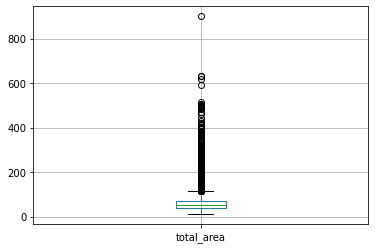

In [34]:
df.boxplot('total_area');

In [35]:
df[df['total_area'] == df['total_area'].max()] # проверим квартиру с максимальной площадью

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,NaN,...,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Значение 900 квадратных метров выбивается, однако судя по стоимости, количеству комнат и нахождению в Санкт-Петербурге, можно предположить, что такое все-таки может быть, оставим и это значение.

Чтобы далее можно было заполнить пропуски и обраватывать другие данные, разделим общую площадь на 6 категорий:
* `tiny` - объекты общей площадью до 30 кв.м.
* `small` - объекты общей площадью от 30 до 60 кв.м.
* `medium` - объекты общей площадью от 60 до 120 кв.м.
* `large` - объекты общей площадью от 120 до 240 кв.м.
* `huge` - объекты общей площадью от 240 до 480 кв.м.
* `giant` - объекты общей площадью более 480 кв.м.

In [36]:
# функция для определения категории квартиры по общей площади
def categorize_area(area):
    if area <= 30:
        return 'tiny'
    elif 30 < area <= 60:
        return 'small'
    elif 60 < area <= 120:
        return 'medium'
    elif 120 < area <= 240:
        return 'large'
    elif 240 < area <= 480:
        return 'huge'
    else:
        return 'giant'

In [37]:
df['area_type'] = df['total_area'].apply(categorize_area) # создаем новую колонку с типом каждой квартиры

Проверим как соотносится жилая площадь к общей площади, а также как площадь кухни соотносится с разницей общей и жилой площадей. Для этого создадим новые колонки с этими значениями.

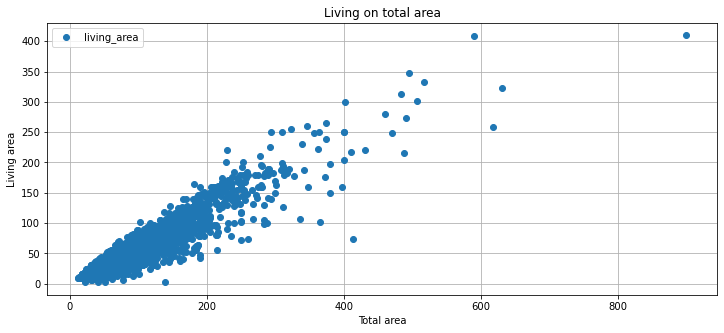

In [39]:
# зависимость жилой площади от общей площади
df.plot(
    x='total_area', 
    y='living_area', 
    style='o', 
    title='Living on total area', 
    xlabel='Total area',
    ylabel='Living area',
    grid=True,
    figsize=(12, 5)
);

In [40]:
df['living_area'].corr(df['total_area']) # коэффициент корреляции между жилой и общей площадью

0.9395373338721501

In [41]:
df['total_minus_living_area'] = df['total_area'] - df['living_area'] # разница между общей и жилой площадью

In [42]:
# коэффициент корреляции между площадью кухни и разницей общей и жилой площадей
df['kitchen_area'].corr(df['total_minus_living_area'])

0.7369597312495355

Жилая площадь сильно зависит от общей площади (коэффиент корреляции Пирсона равен `0.94`), поэтому можно заполнить пропуски в жилой площади, зная общую площадь квартиры. Для площади кухни рассмотрим взаимосвязь с разницей между общей и жилой площадью, для большей точности будем считать с учетом разбивки квартир на категории по площади. 

In [43]:
df['living_to_total_area_ratio'] = df['living_area'] / df['total_area']
df['kitchen_to_total_minus_living_area_ratio'] = df['kitchen_area'] / df['total_minus_living_area']

In [44]:
# сводная таблица для соотношений площадей с учетом разбивки по типам квартир в зависимости от площади
df.pivot_table(index='area_type', 
               values=['living_to_total_area_ratio', 'kitchen_to_total_minus_living_area_ratio'], 
               aggfunc='median'
              )

,kitchen_to_total_minus_living_area_ratio,living_to_total_area_ratio
area_type,,
giant,0.189134,0.576360
huge,0.226308,0.595229
large,0.316222,0.597633
medium,0.367647,0.595290
small,0.431522,0.548747
tiny,0.463689,0.586207


Отношение жилой площади к общей для любых квартир не сильно отличается, а вот соотношение площади кухни с разностью
между общей и жилой площадью зависит от типа квартиры (т.е. получается зависит от общей площади), это похоже на правду, потому что для больших квартир кухня все равно остается одна и слишком большой площадью ее не делают, а для маленьких квартир доля кухни соответственно выше. Заменим пропущенные значения для жилой площади и площади кухни в соответствии с полученными коэффициентами.

In [45]:
df[(df['kitchen_area'] + df['living_area']) > df['total_area']].shape[0]

64

<div class="alert alert-info">
    Оказалось, что в исходных данных 64 квартиры с общей площадью меньшей, чем сумма жилой и площади кухни. Поэтому после заполнения пропусков таким же образом, как и ранее, уберем значения для площадей кухни, т.к. зависимость от площади кухни не так выражена.

In [46]:
for t in df['area_type'].unique():
    
    df.loc[(df['area_type'] == t) & (df['living_area'].isna()), 'living_area'] = \
    df['total_area'] * df.loc[df['area_type'] == t, 'living_to_total_area_ratio'].median()
    
    df.loc[(df['area_type'] == t) & (df['kitchen_area'].isna()), 'kitchen_area'] = \
    (df['total_area'] - df['living_area']) * \
    df.loc[df['area_type'] == t, 'kitchen_to_total_minus_living_area_ratio'].median()


In [47]:
df.loc[(df['kitchen_area'] + df['living_area']) > df['total_area'], 'kitchen_area'] = np.nan
df[(df['kitchen_area'] + df['living_area']) > df['total_area']].shape[0]

0

#### Цена квартир `last_price`

In [48]:
df['last_price'].sort_values() # проверим значения цены

8793         12190.0
17456       430000.0
14911       430000.0
16274       440000.0
17676       450000.0
            ...     
15651    300000000.0
1436     330000000.0
14706    401300000.0
19540    420000000.0
12971    763000000.0
Name: last_price, Length: 23699, dtype: float64

<AxesSubplot:>

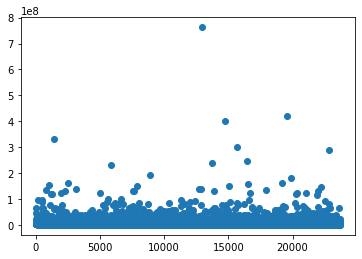

In [49]:
df['last_price'].plot(style='o')

<AxesSubplot:>

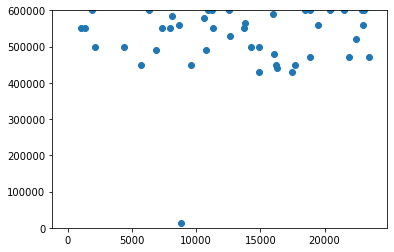

In [50]:
df['last_price'].plot(style='o', ylim=(0, 600000))

Выбивается минимальное значение, проверим его

<div class="alert alert-info">
    Добавил графики, чтобы было лучше видно выбросы. Также из графиков можно заметить, что есть всего несколько квартир дешевле 500 тыс. и дороже 300 млн, проверим эти квартиры дополнительно.

In [51]:
df.loc[8793]

total_images                                                  7
last_price                                              12190.0
total_area                                                109.0
first_day_exposition                        2019-03-20 00:00:00
rooms                                                         2
ceiling_height                                             2.75
floors_total                                               25.0
living_area                                                32.0
floor                                                        25
is_apartment                                                NaN
studio                                                    False
open_plan                                                 False
kitchen_area                                               40.5
balcony                                                       0
locality_name                                   Санкт-Петербург
airports_nearest                        

Квартира в Санкт-Петербурге площадью 109 кв. метров, скорее всего ошибка в написании цены, проверим, есть ли еще похожие квартиры

In [52]:
df.query('locality_name == "Санкт-Петербург" and total_area == 109')['last_price'].sort_values()

8793        12190.0
23291     7500000.0
3614      8300000.0
17727    10000000.0
2452     10500000.0
10601    10900000.0
18239    11300000.0
17570    12180000.0
14705    12500000.0
18169    12600000.0
5035     13200000.0
21989    13500000.0
16410    13500000.0
5198     13500000.0
12771    14400000.0
11843    16500000.0
19382    20786000.0
17932    20850000.0
18834    21600000.0
14143    25000000.0
7186     25000000.0
16247    38000000.0
Name: last_price, dtype: float64

Да, похоже, что при написании цены ошиблись и не указали лишние нули, исправим это

In [53]:
df.loc[8793, 'last_price'] = df.loc[8793, 'last_price'] * 1000

In [54]:
# проверим квартиры с высокой ценой
df[df['last_price'] > 300000000][['last_price', 'rooms', 'total_area', 'locality_name']].sort_values('last_price') 

,last_price,rooms,total_area,locality_name
1436,330000000.0,3,190.0,Санкт-Петербург
14706,401300000.0,5,401.0,Санкт-Петербург
19540,420000000.0,12,900.0,Санкт-Петербург
12971,763000000.0,7,400.0,Санкт-Петербург


In [55]:
# проверим квартиры с низкой ценой
df[df['last_price'] < 500000][['last_price', 'rooms', 'total_area', 'locality_name']].sort_values('last_price') 

,last_price,rooms,total_area,locality_name
14911,430000.0,2,54.0,посёлок станции Свирь
17456,430000.0,1,30.4,Сланцы
16274,440000.0,1,40.0,деревня Старополье
5698,450000.0,2,42.0,городской посёлок Будогощь
9581,450000.0,2,43.4,деревня Старополье
16219,450000.0,2,38.5,деревня Вахнова Кара
17676,450000.0,1,36.5,деревня Ям-Тесово
18867,470000.0,1,41.0,деревня Выскатка
21912,470000.0,1,37.0,посёлок Совхозный
23484,470000.0,2,44.5,Сланцы


Остальные данные похожи на правду, высокая цена у квартир большой площади и в Санкт-Петербурге, низкая цена у небольших квартир в деревнях и поселках. Значение в 763 млн. выбивается, но нет достаточных оснований сказать, что это точно ошибка.

#### Остальные стобцы

В оставшихся колонках нет возможности заменить пропущенные значения, поэтому оставим их. Проверим только выбивающиеся данные.

<AxesSubplot:>

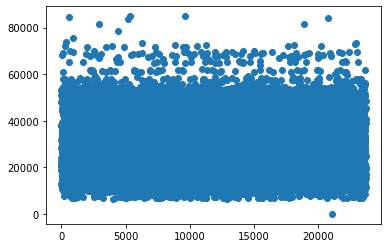

In [56]:
df['airports_nearest'].plot(style='o')

Выбивается значение 0 метров до аэропорта, такого быть не может, поэтому заменим его на пропущенное

In [57]:
df.loc[df['airports_nearest'] == 0, 'airports_nearest'] = np.nan

<AxesSubplot:>

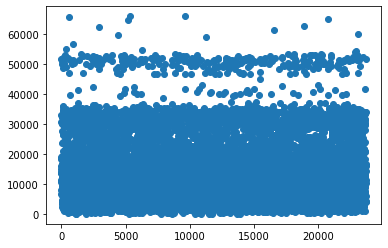

In [58]:
df['cityCenters_nearest'].plot(style='o')

<AxesSubplot:>

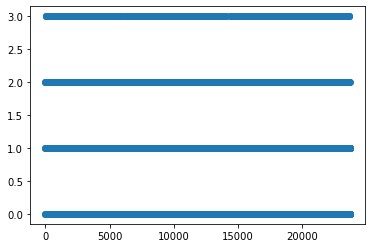

In [59]:
df['parks_around3000'].plot(style='o')

<AxesSubplot:>

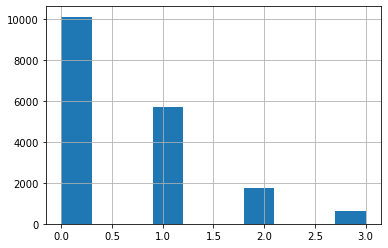

In [60]:
df['parks_around3000'].hist()

<AxesSubplot:>

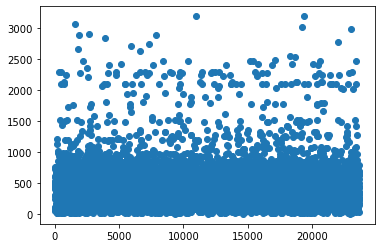

In [61]:
df['parks_nearest'].plot(style='o')

<AxesSubplot:>

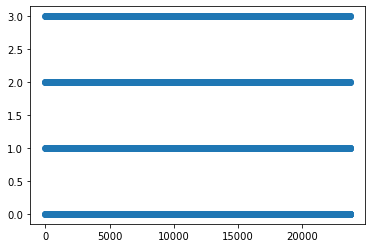

In [62]:
df['ponds_around3000'].plot(style='o')

<AxesSubplot:>

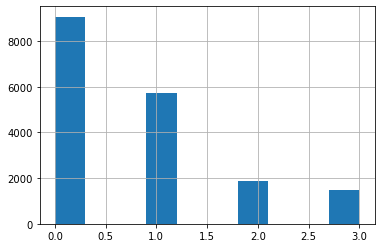

In [63]:
df['ponds_around3000'].hist()

<div class="alert alert-info">
    Тоже добавил гистограму, также выбросов нет.

<AxesSubplot:>

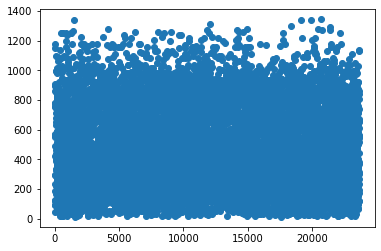

In [64]:
df['ponds_nearest'].plot(style='o')

<AxesSubplot:>

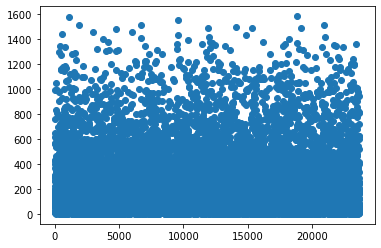

In [65]:
df['days_exposition'].plot(style='o')

В значениях `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition` нет выбиващихся значений.

<div class="alert alert-info">
На этом этапе обработали данные:
<ul>
    <li>Изменен тип данных для даты на datetime</li>
    <li>Пропуски в данных по количеству балконов заменены на 0</li>
    <li>Устранены неявные дубликаты в названиях населенных пунктов</li>
    <li>Исправлены неправдоподбные значения для высоты потолков, пропуски заменены на медианные значения в зависимости от населенного пункта</li>
    <li>Убраны значения количества этажей более 37, т.к. таких жилых домов нет в данных регионах</li>
    <li>Заполнены пропуски в данных жилой площади на основании данных общей площади, т.к. эти величины коррелируют друг с другом</li>
    <li>В случаях, где это возможно, устранены пропуски для площади кухни, на основании зависимости площади кухни от общей и жилой площадей с учетом типа квартиры по площади</li>
    <li>Устранены ошибки в данных по стоимости квартир и расстоянии до аэропорта</li>
    <li>Проверены все остальные данные, проблем в них обнаружено не было</li>
    </ul>

### Посчитайте и добавьте в таблицу новые столбцы

In [66]:
# добавляем новые столбцы
df['cost_per_sqrm'] = df['last_price'] / df['total_area'] # стоимость одного квадратного метра
df['day_of_week'] = df['first_day_exposition'].dt.dayofweek # день недели публикации объявления
df['month'] = df['first_day_exposition'].dt.month # месяц публикации объявления
df['year'] = df['first_day_exposition'].dt.year # год публикации объявления

In [67]:
# функция для добавления типа этажа (первый, последний, другой)
def categorize_floor(floor, floors_total):
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif floor != floors_total and floors_total > 0:
        return 'другой'
    else:
        return 'unknown'

In [68]:
# создаем столбец с применением созданной функции
df['floor_type'] = df.apply(lambda x: categorize_floor(x['floor'], x['floors_total']), axis=1)

In [69]:
# расстояние до центра города в километрах, округленное до целого значения
df['cityCenters_nearest_km'] = (df['cityCenters_nearest'] / 1000).round()

In [70]:
df.head() # проверим добавление новых столбцов

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,area_type,total_minus_living_area,living_to_total_area_ratio,kitchen_to_total_minus_living_area_ratio,cost_per_sqrm,day_of_week,month,year,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,medium,57.0,0.472222,0.438596,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.63,11.0,18.600000,1,NaN,...,small,21.8,0.460396,0.504587,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.70,5.0,34.300000,4,NaN,...,small,21.7,0.612500,0.382488,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.70,14.0,95.023669,9,NaN,...,large,NaN,NaN,NaN,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,medium,68.0,0.320000,0.602941,100000.000000,1,6,2018,другой,8.0


<div class="alert alert-info">
    На данном этапе для каждого объявления добавлены значения стоимости одного квадратного метра, дня недели, месяца и года, когда было подано объявление. Также добавлены категории этажа, на котором находится квартира - первый, последний или другой (значение unknown там, где точно невозможно установить тип этажа). Посчитаны расстояния до центра населенного пункта в километрах, округленные до целых значений.

### Проведите исследовательский анализ данных

#### Общая площадь, жилая площадь, площадь кухни

Text(0, 0.5, 'Ads count')

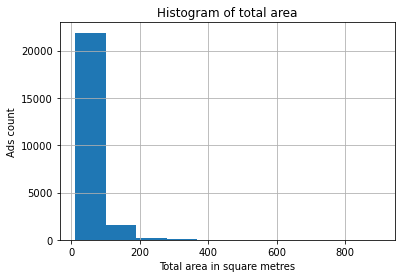

In [71]:
df['total_area'].hist() # гистограма общей площади
plt.title('Histogram of total area')
plt.xlabel('Total area in square metres')
plt.ylabel('Ads count')

Text(0, 0.5, 'Ads count')

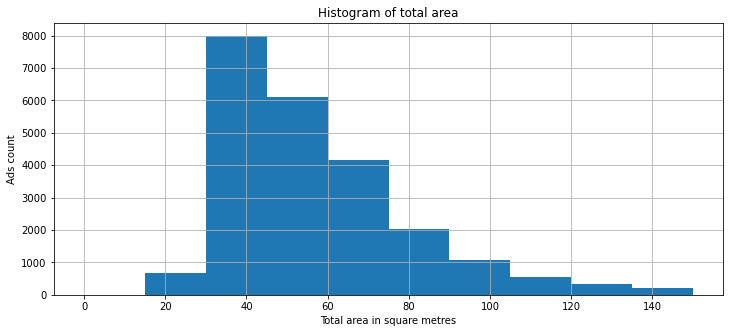

In [72]:
df['total_area'].hist(figsize=(12, 5), range=(0, 150)) # уменьшим интервал, чтобы было нагляднее
plt.title('Histogram of total area')
plt.xlabel('Total area in square metres')
plt.ylabel('Ads count')

Больше всего квартир площадью от 30 до 50 квадратных метров. Это связано с тем, что это наиболее доступные квартиры, в которых комфортно жить (не совсем маленькие студии и не слишком дорогие большие квартиры), строилось таких квартир больше, чем остальных. Такая площадь соответствует одно-двухкомнатным квартирам, далее мы проверим, соответствуют ли эти данные по площади с данными по количеству комнат. С увеличением площади, уменьшается количество квартир, т.к. это менее распространенный тип жилья.

Text(0, 0.5, 'Ads count')

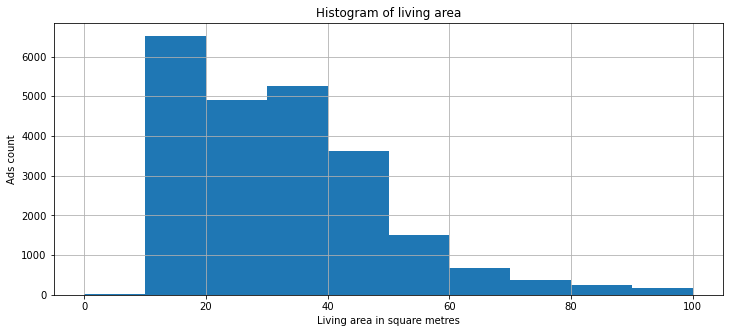

In [73]:
df['living_area'].hist(figsize=(12, 5), range=(0, 100)) # гистограма жилой площади
plt.title('Histogram of living area')
plt.xlabel('Living area in square metres')
plt.ylabel('Ads count')

Жилая площадь зависит от общей площади, поэтому мы видим похожую картину. Большинство квартир с жилой площадью 15-30 кв. метров соответствует квартирам с общей площадью 30-50 кв. м.

Text(0, 0.5, 'Ads count')

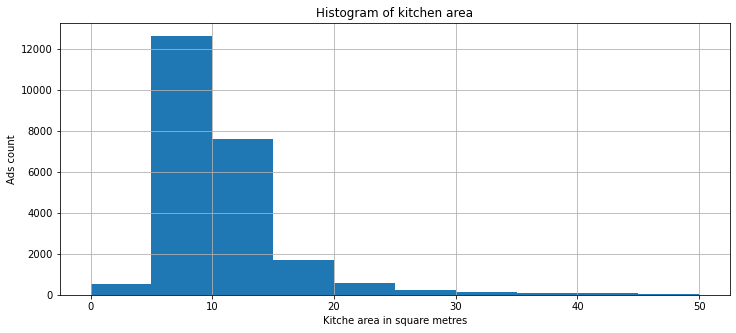

In [74]:
df['kitchen_area'].hist(figsize=(12, 5), range=(0, 50)) # гистограмма площади кухни
plt.title('Histogram of kitchen area')
plt.xlabel('Kitche area in square metres')
plt.ylabel('Ads count')

На гистограмме площади кухни появляются нулевые значения, которых нет для общей и жилой площадей - это квартиры студии. В остальном вид также похож и на гистограмму общей площади, и на гистограмму жилой площади, т.к. площадь кухни также зависит от этих показателей. Однако значений более 45 кв.м. появляется уже значительно меньше, потому что для больших квартир площадь кухни перестает увеличиваться с увеличением общей площади.

#### Стоимость квартир

Text(0, 0.5, 'Ads count')

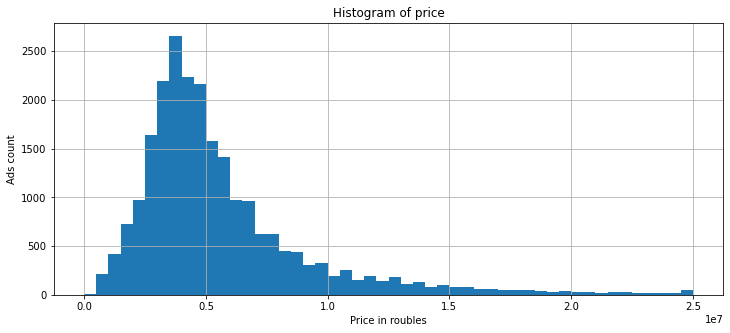

In [75]:
df['last_price'].hist(bins=50, figsize=(12, 5), range=(0, 25000000)) # гистограмма стоимости квартир
plt.title('Histogram of price')
plt.xlabel('Price in roubles')
plt.ylabel('Ads count')

Стоимость также зависит от площади, поэтому гистрограмма похожего вида, наибольшее количество квартир стоимостью `2.5` - `5.0` млн. руб.

#### Количество комнат

Text(0, 0.5, 'Ads count')

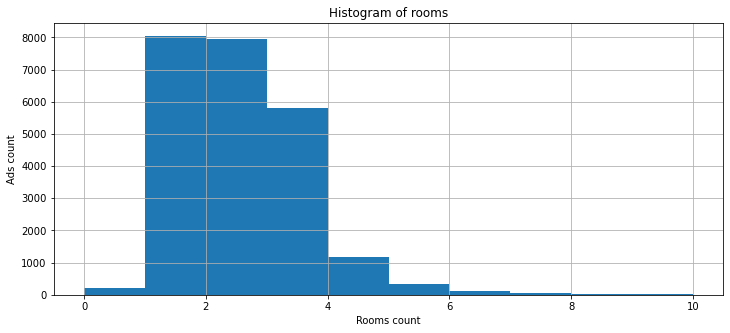

In [76]:
df['rooms'].hist(figsize=(12, 5), range=(0, 10)) # гистограмма количества комнат в квартирах
plt.title('Histogram of rooms')
plt.xlabel('Rooms count')
plt.ylabel('Ads count')

Как мы и предположили в выводах для общей площади квартир - наибольшее количество одно- и двухкомнатных квартир, квартир с более чем 4 комнатами значительно меньше.

#### Высота потолков

Text(0, 0.5, 'Ads count')

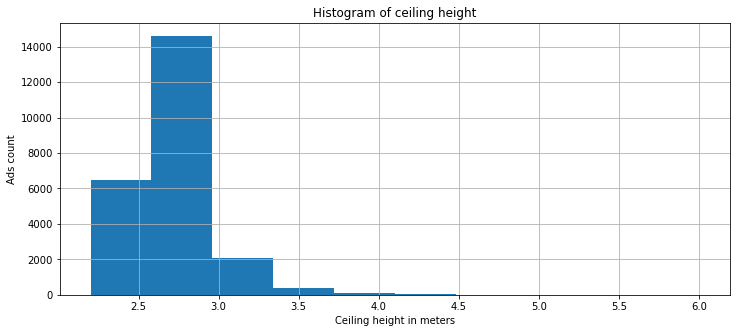

In [77]:
df['ceiling_height'].hist(figsize=(12, 5)) # гистограмма высоты потолка в квартирах
plt.title('Histogram of ceiling height')
plt.xlabel('Ceiling height in meters')
plt.ylabel('Ads count')

Наибольшее количество квартир с потолками высотой `2.6` - `3.0` метров, значительная часть с потолками `2.2` - `2.6` м, с более высокими потолками количество квартир уменьшается

#### Этажи

Text(0, 0.5, 'Ads count')

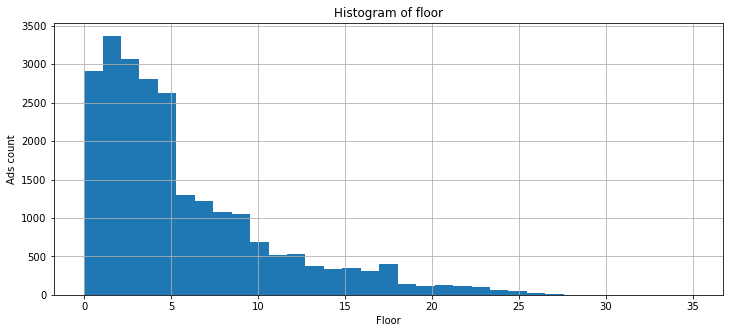

In [78]:
df['floor'].hist(bins=33, figsize=(12, 5), range=(0, 35)) # гистограмма этажей
plt.title('Histogram of floor')
plt.xlabel('Floor')
plt.ylabel('Ads count')

Больше всего объявлений с квартирами до пятого этажа, начиная с шестого этажа заметен резкий скачок с уменьшением количества, это связано с тем, что многие дома пятиэтажные, поэтому больше квартир на этажах до 5-го.

Text(0, 0.5, 'Ads count')

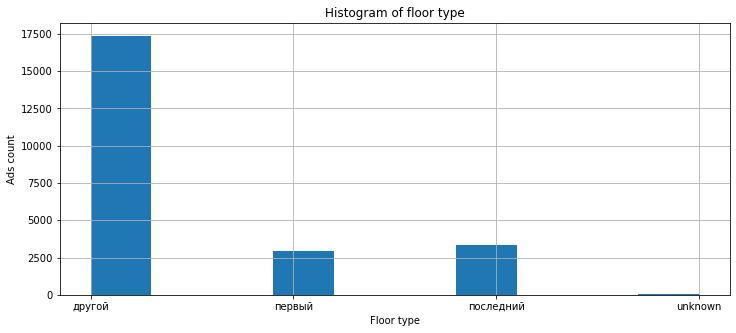

In [79]:
df['floor_type'].hist(figsize=(12, 5)) # гистограмма типа этажей
plt.title('Histogram of floor type')
plt.xlabel('Floor type')
plt.ylabel('Ads count')

Наибольшее количество объявлений с типом этажа `другой`, это объяснимо, потому что это любые этажи, кроме первого и последнего, их естественно будет больше.

Text(0, 0.5, 'Ads count')

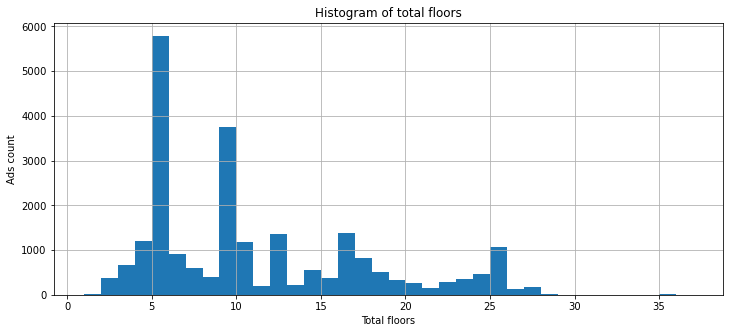

In [80]:
df['floors_total'].hist(bins=36, figsize=(12, 5)) # гистограмма общего количества этажей в доме
plt.title('Histogram of total floors')
plt.xlabel('Total floors')
plt.ylabel('Ads count')

Наибольшее количество домов с пятью этажами - точно так, как мы и предположили в выводе про этажи конкретной квартиры. Также заметны пики на 9, 12, 16 - это тоже распространенные типы домов

#### Расстояние до центра населенного пункта (в метрах)

Text(0, 0.5, 'Ads count')

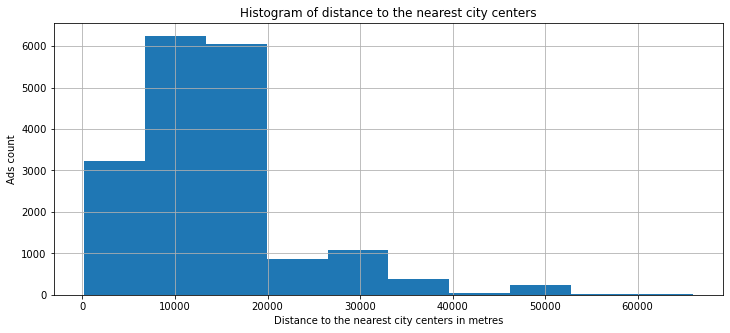

In [81]:
df['cityCenters_nearest'].hist(figsize=(12, 5)) # гистограмма расстояния до центра города
plt.title('Histogram of distance to the nearest city centers')
plt.xlabel('Distance to the nearest city centers in metres')
plt.ylabel('Ads count')

Большинство квартир находится на расстоянии от 6 до 20 км до центра города, это объясняется размерами городов. Квартир ближе к центру меньше, потому что радиус в 6 км вмещает в себя меньше домов, чем радиус 20 км. Далее количество квартир уменьшается потому что многие населенные пункты просто меньше по размеру.

#### Расстояние до ближайшего аэропорта (в метрах)

Text(0, 0.5, 'Ads count')

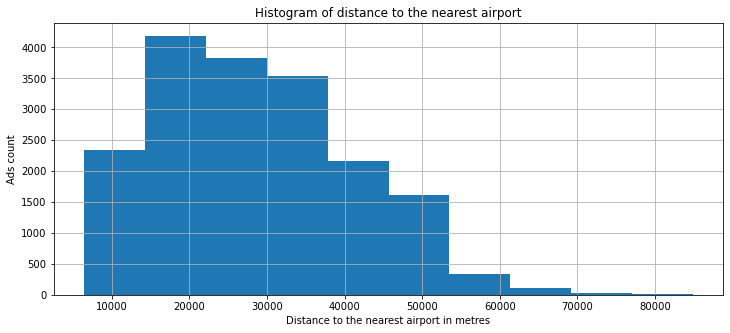

In [82]:
df['airports_nearest'].hist(figsize=(12, 5)) # гистограмма расстояния до аэропорта
plt.title('Histogram of distance to the nearest airport')
plt.xlabel('Distance to the nearest airport in metres')
plt.ylabel('Ads count')

Наибольшее количество квартир находится на расстоянии 15-35 км от аэропорта, это обусловлено типичным расположением аэропортов от городов на некотором удалении.

#### Расстояние до ближайшего парка (в метрах)

Text(0, 0.5, 'Ads count')

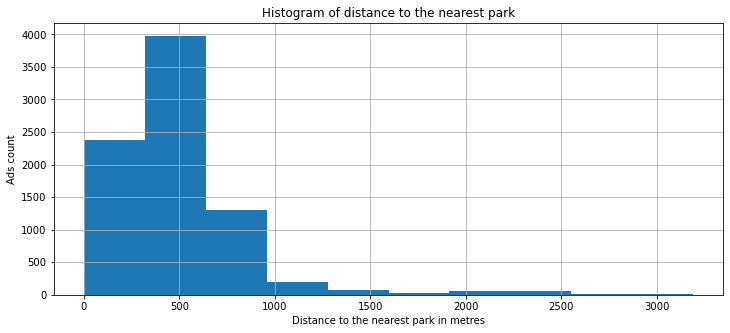

In [83]:
df['parks_nearest'].hist(figsize=(12, 5)) # гистограмма расстояния до парков
plt.title('Histogram of distance to the nearest park')
plt.xlabel('Distance to the nearest park in metres')
plt.ylabel('Ads count')

Для квартир с парками поблизости большинство из них находится в радиусе 1 км

#### Дата размещения объявления

Text(0, 0.5, 'Ads count')

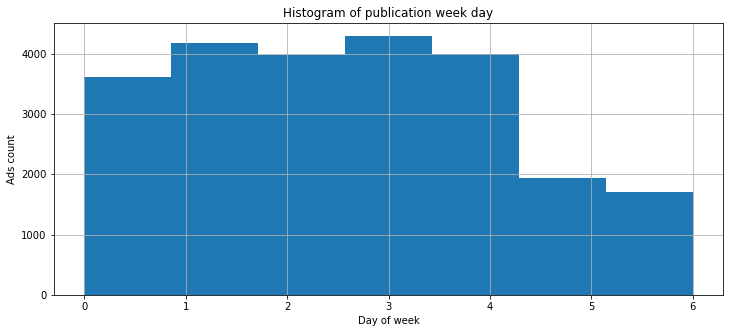

In [84]:
df['day_of_week'].hist(bins=7, figsize=(12, 5)) # гистограмма дней недели (размещение объявлений)
plt.title('Histogram of publication week day')
plt.xlabel('Day of week')
plt.ylabel('Ads count')

<AxesSubplot:title={'center':'Number of ads per day of the week'}, xlabel='Day of the week', ylabel='Ads count'>

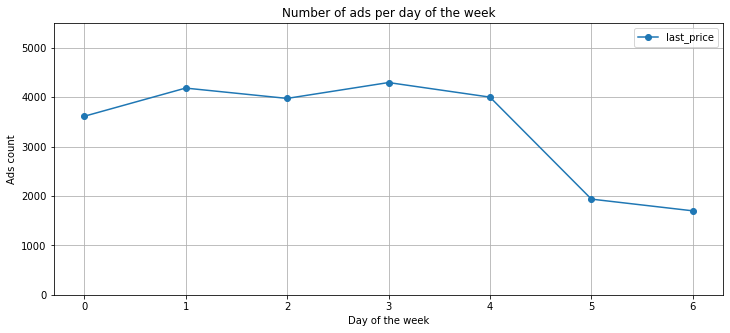

In [85]:
(
    df
    .pivot_table(index='day_of_week', values='last_price', aggfunc='count')
    .plot(ylim=(0, 5500), 
          figsize=(12, 5), 
          grid=True, 
          style='o-', 
          title='Number of ads per day of the week',
          xlabel='Day of the week',
          ylabel='Ads count'
         )
)

В выходные дни примерно в 2 раза меньше размещается объявлений, чем в любой будний день. Люди стараются не заниматься делами в выходные дни и размещают объявления в рабочие дни, также если объявления размещают риелтор, то они тоже делают это чаще по будням.

Text(0, 0.5, 'Ads count')

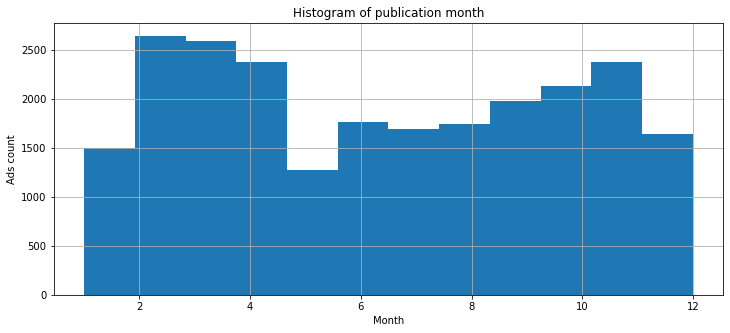

In [86]:
df['month'].hist(bins=12, figsize=(12, 5)) # гистограмма месяцев (размещение объявлений)
plt.title('Histogram of publication month')
plt.xlabel('Month')
plt.ylabel('Ads count')

<AxesSubplot:title={'center':'Number of ads per month'}, xlabel='Month', ylabel='Ads count'>

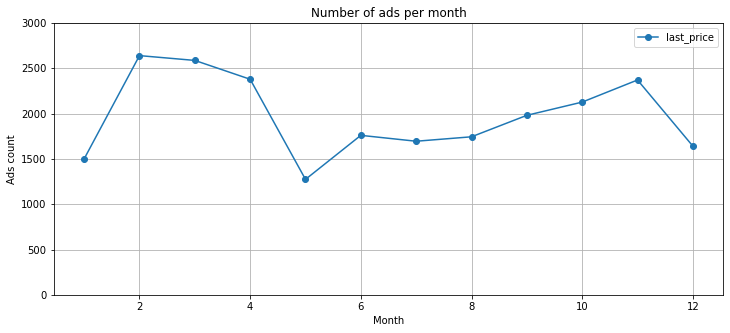

In [87]:
(
    df
    .pivot_table(index='month', values='last_price', aggfunc='count')
    .plot(ylim=(0, 3000), 
          figsize=(12, 5), 
          grid=True, 
          style='o-', 
          title='Number of ads per month',
          xlabel='Month',
          ylabel='Ads count'
         )
)

Наименьшее количество объявлений заметно в январе, мае и декабре. Это связано с большими праздниками в эти месяцы, люди заняты отдыхом или подготовкой к Новому Году.

#### Продолжительность размещения объявлений

Text(0, 0.5, 'Ads count')

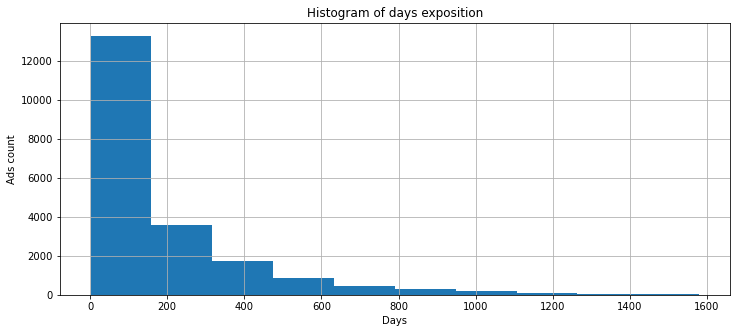

In [88]:
df['days_exposition'].hist(figsize=(12, 5)) # гистограмма количества дней размещения объявления
plt.title('Histogram of days exposition')
plt.xlabel('Days')
plt.ylabel('Ads count')

In [89]:
df['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

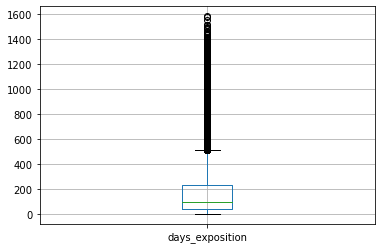

In [90]:
df.boxplot('days_exposition') 

Среднее 180 и медиана 95 дней сильно отличаются, это говорит о том, что есть большие значения, которые смещают среднее, это так же видно по гистограмме и графику boxplot. Половина всех объявлений размещалась не более, чем на 95 дней, но остальные данные смещают серднее, скорее всего это связано с тем, что некоторые объявления просто не убирают, они продолжают быть активными даже несколько лет. Продажи за менее чем 45 дней можно назвать быстрыми, за более чем 232 дня - долгими.

<AxesSubplot:xlabel='first_day_exposition', ylabel='days_exposition'>

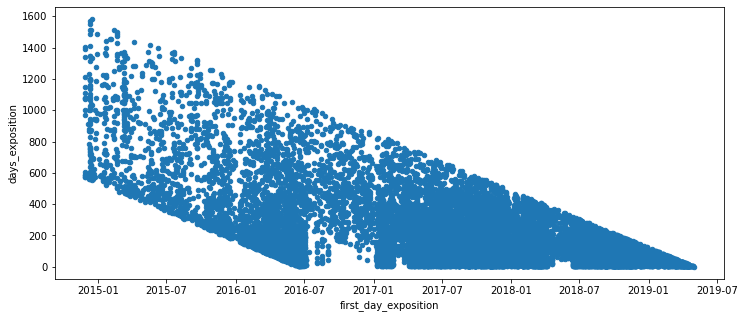

In [91]:
# количество дней размещения в зависимости от даты размещения
df.plot(x='first_day_exposition', y='days_exposition', kind='scatter', figsize=(12, 5))

<AxesSubplot:xlabel='first_day_exposition'>

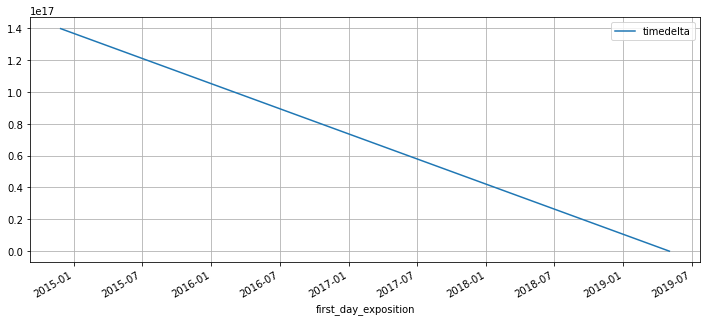

In [92]:
# количество дней между днем размещения объявления и последним днем, по которому есть данные
df['timedelta'] = df['first_day_exposition'].max() - df['first_day_exposition']

df.plot(x='first_day_exposition', y='timedelta', grid=True, figsize=(12, 5))

Видно, что с увеличением года уменьшается количество дней размещения - потому что прошло меньше дней до даты отсчета и оно не может быть больше. Если построить график зависимости разности между датой размещения и датой отсчета от даты размещения, то получится как раз такая же линия, которую можно заметить на графике с количеством дней размещения. Также есть особенность в данных до июля 2016 года - нет объявлений, которые имели бы небольшие сроки размещения. Вероятно, это связано с тем, что только с июля 2016 года эти данные стали собирать, таким образом  для объявлений, размещенных до этой даты, смогли посчитать продолжительность размещения только для тех объявлений, которые на тот момент еще были не убраны, поэтому остались только те, которые продолжали быть опубликованы на тот момент.

#### Зависимость цены от общей площади, жилой площади и площади кухни

<AxesSubplot:title={'center':'Price on total area'}, xlabel='Area in square metres', ylabel='Price in roubles'>

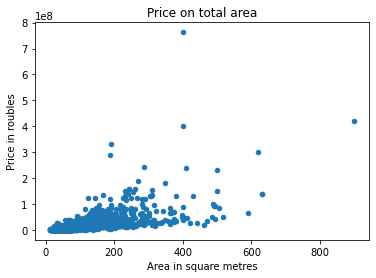

In [93]:
# график зависимости цены от общей площади
df.plot(x='total_area', 
        y='last_price', 
        kind='scatter', 
        title='Price on total area',
        xlabel='Area in square metres',
        ylabel='Price in roubles'
       ) 

Можно заметить зависимость цены от общей площади, с увеличением площади, увеличивается и стоимость. Точка с максимальной стоимостью выбивается, поэтому посмотрим что изменится, если не учитывать данное объявление.

In [94]:
last_price_max = df['last_price'].max() # создадим переменную с максимальной стоимостью

<AxesSubplot:title={'center':'Price on total area'}, xlabel='Area in square metres', ylabel='Price in roubles'>

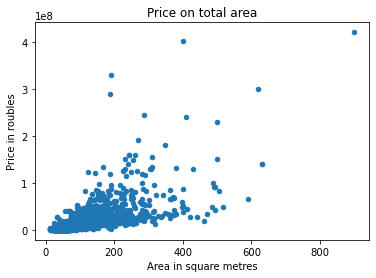

In [95]:
# график зависимости цены от общей площади без учета объявления с максимальной стоимостью
df.query('last_price != @last_price_max').plot(x='total_area', 
                                               y='last_price', 
                                               kind='scatter',
                                               title='Price on total area',
                                               xlabel='Area in square metres',
                                               ylabel='Price in roubles'
                                              )

In [96]:
df['last_price'].describe()

count    2.369900e+04
mean     6.542063e+06
std      1.088699e+07
min      4.300000e+05
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [97]:
df['last_price'].corr(df['total_area'])

0.6537407142641287

In [98]:
df.query('last_price != @last_price_max')['last_price'].describe()

count    2.369800e+04
mean     6.510142e+06
std      9.715084e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      4.200000e+08
Name: last_price, dtype: float64

In [99]:
df.query('last_price != @last_price_max')['last_price'].corr(
    df.query('last_price != @last_price_max')['total_area']
)

0.7026597154316849

Коэффициент корреляции Пирсона равен `0.65` - это говорит о том, что есть положительная зависимость стоимости квартиры от ее общей площади. Если не учитывать объявление с максимальной ценой, то коэффициент корреляции увеличивается до `0.70`, что говорит о том, что скорее всего все-таки это объявление выбивается, но стоимость зависит не только от площади, поэтому возможно есть другие факторы, которые сильно увеличивают стоимость данной квартиры. Ранее мы разделили площадь квартир на 6 категорий, посмотрим зависимости стоимости с учетом категорий, взяв медианные значения для каждой категории.

<AxesSubplot:title={'center':'Price on area type'}, xlabel='Area type', ylabel='Price in roubles'>

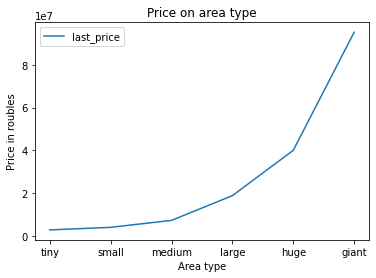

In [100]:
# график зависимости стоимости от общей площади с учетом разделения квартир на категории общей площади
# медианные значения общей площади для каждой категории
(
    df.pivot_table(index='area_type', values='last_price', aggfunc='median')
    .sort_values('area_type', ascending=False)
    .plot(title='Price on area type', xlabel='Area type', ylabel='Price in roubles')
)

In [101]:
# коэффициенты корреляции для стоимости и общей площади в зависимости от типа квартиры
df.groupby('area_type')[['last_price', 'total_area']].corr()

last_price  total_area
area_type                                   
giant     last_price    1.000000    0.789037
          total_area    0.789037    1.000000
huge      last_price    1.000000    0.185671
          total_area    0.185671    1.000000
large     last_price    1.000000    0.286317
          total_area    0.286317    1.000000
medium    last_price    1.000000    0.547707
          total_area    0.547707    1.000000
small     last_price    1.000000    0.407466
          total_area    0.407466    1.000000
tiny      last_price    1.000000    0.124573
          total_area    0.124573    1.000000

На этом графике уже отчетливо видно, что зависимость все-таки не линейная. Можно говорить только о положительной зависимости. Коэффициент корреляции близок к единице только для самых больших по площади квартир. Так получается потому, что есть еще несколько факторов, которые влияют на стоимость.

In [102]:
# создадим список из 10 населенных пунктов, в которых наибольшее количество объявлений
top_10 = []
for i in df['locality_name'].value_counts().head(10).reset_index()['index']:
    top_10.append(i)

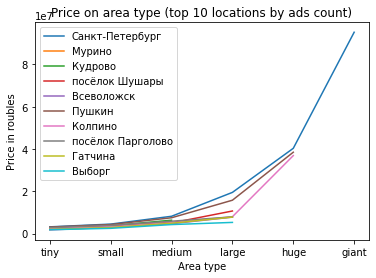

In [103]:
for name in top_10:
     plt.plot(
         df.query('locality_name == @name')
         .groupby('area_type')
         .agg({'last_price': 'median'})
         .sort_values('area_type', ascending=False)
     )
plt.legend(top_10)
plt.title('Price on area type (top 10 locations by ads count)')
plt.xlabel('Area type')
plt.ylabel('Price in roubles')
plt.show()

Построили графики для зависимости стоимости квартиры от ее типа по площади. Общий вид совпадает с графиков по всем населенным пунктам, что ожидаемо. Можно также заметить, что наибольшие различия в стоимости по населенным пунктам проявляются для больших квартир по площади.

<AxesSubplot:title={'center':'Price on living type'}, xlabel='Living area in square metres', ylabel='Price in roubles'>

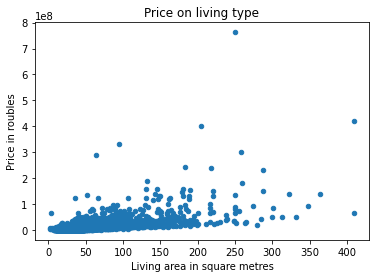

In [104]:
df.plot(x='living_area', 
        y='last_price', 
        kind='scatter', 
        title='Price on living type', 
        xlabel='Living area in square metres', 
        ylabel='Price in roubles') # график зависимости цены от жилой площади

<AxesSubplot:title={'center':'Price on living area'}, xlabel='Area type', ylabel='Price in roubles'>

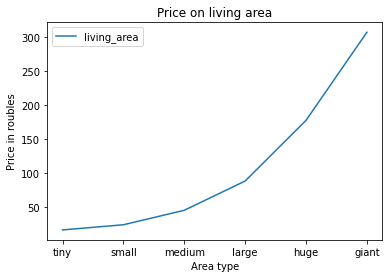

In [105]:
# график зависимости стоимости от жилой площади с учетом разделения квартир на категории общей площади
# медианные значения жилой площади для каждой категории
(
    df.pivot_table(index='area_type', values='living_area', aggfunc='median')
    .sort_values('area_type', ascending=False)
    .plot(title='Price on living area', xlabel='Area type', ylabel='Price in roubles')
)

In [106]:
df['last_price'].corr(df['living_area']) # коэффициент корреляции стоимости от жилой площади

0.585751546872633

In [107]:
df['total_area'].corr(df['living_area']) # коэффициент корреляции жилой площади от общей площади

0.9467300725563675

Зависимость стоимости квартиры от жилой площади идентична зависимости от общей площади, потому что жилая площадь сильно зависит от общей (коэффициент корреляции равен `0.95`). Поэтому для жилой площади все выводы идентичны выводам по зависимоти от общей площади.

<AxesSubplot:title={'center':'Price on kitchen area'}, xlabel='Kitchen area in square metres', ylabel='Price in roubles'>

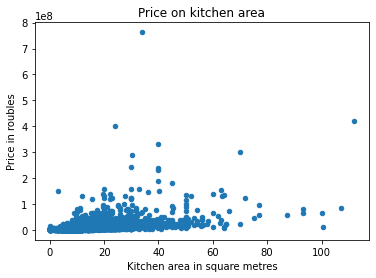

In [108]:
# график зависимости цены от площади кухни
df.plot(x='kitchen_area', 
        y='last_price', 
        kind='scatter',
        title='Price on kitchen area', 
        xlabel='Kitchen area in square metres', 
        ylabel='Price in roubles'
       ) 

In [109]:
df['kitchen_area'].corr(df['last_price'])

0.47980273701481063

Из графика видно, что зависимость стоимости от площади кухни слабая, об этом также говорит коэффициент корреляции `0.49`, площадь кухни не сильно отличается в большинстве квартир, поэтому и на стоимость сильнее влияют другие факторы, а не площадь кухни.

#### Зависимость цены от этажности

<AxesSubplot:title={'center':'Last price on floor'}, xlabel='Floor', ylabel='Price in roubles'>

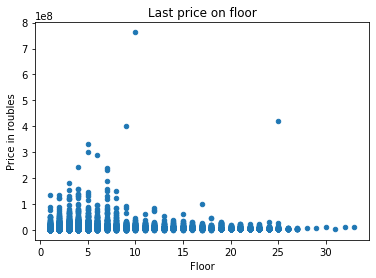

In [110]:
# заивисмость стоимости квартиры от этажа
df.plot(x='floor', 
        y='last_price', 
        kind='scatter',
        title='Last price on floor',
        xlabel='Floor',
        ylabel='Price in roubles'
       ) 

<AxesSubplot:title={'center':'Median price on floor'}, xlabel='Floor', ylabel='Price in roubles'>

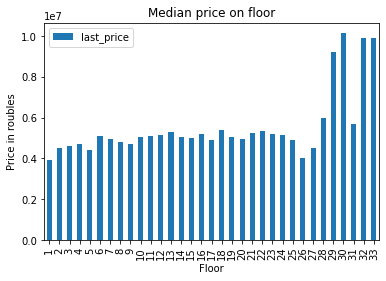

In [111]:
# заивисмость медианной стоимости квартиры от этажа
(
    df
    .pivot_table(index='floor', values='last_price', aggfunc='median')
    .sort_values('floor')
    .plot(y='last_price', 
          kind='bar',
          title='Median price on floor',
          xlabel='Floor',
          ylabel='Price in roubles'
         )
)

In [112]:
df[df['floor'] > 27]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,total_minus_living_area,living_to_total_area_ratio,kitchen_to_total_minus_living_area_ratio,cost_per_sqrm,day_of_week,month,year,floor_type,cityCenters_nearest_km,timedelta
397,15,5990000.0,54.0,2018-03-22,2,2.7,36.0,21.4,28,NaN,...,32.6,0.396296,0.573620,110925.925926,3,3,2018,другой,20.0,407 days
1917,13,10150000.0,74.0,2017-11-17,2,2.8,35.0,34.4,30,NaN,...,39.6,0.464865,0.328283,137162.162162,4,11,2017,другой,20.0,532 days
11079,16,9200000.0,75.0,2019-02-22,2,2.7,36.0,40.0,29,NaN,...,35.0,0.533333,0.342857,122666.666667,4,2,2019,другой,20.0,70 days
11575,9,9900000.0,101.0,2016-04-28,3,2.7,33.0,53.0,32,False,...,48.0,0.524752,0.437500,98019.801980,3,4,2016,другой,20.0,1100 days
18218,4,9900000.0,101.0,2018-09-27,3,2.7,35.0,53.4,33,NaN,...,47.6,0.528713,0.287815,98019.801980,3,9,2018,другой,20.0,218 days
18629,20,5700000.0,54.0,2017-12-08,1,2.7,35.0,21.0,31,NaN,...,33.0,0.388889,0.545455,105555.555556,4,12,2017,другой,20.0,511 days


Зависимости от этажа нет, видно увеличение стоимости для этажей выше 27, однако это связано скорее всего с тем, что таких квартир всего 6, выборка не показательна в данном случае, на каждый из этих этажей приходится всего по одному объявлению.

<AxesSubplot:title={'center':'Price on floor type'}, xlabel='Floor type', ylabel='Price in roubles'>

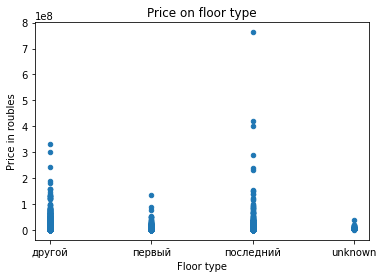

In [113]:
# заивисмость стоимости квартиры от типа этажа
df.plot(x='floor_type', 
        y='last_price', 
        kind='scatter', 
        title='Price on floor type',
        xlabel='Floor type',
        ylabel='Price in roubles'
       ) 

In [114]:
df.groupby('floor_type')['last_price'].median() # медианная стоимость в зависимости от типа этажа

floor_type
unknown      5235000.0
другой       4850000.0
первый       3900000.0
последний    4300000.0
Name: last_price, dtype: float64

<AxesSubplot:title={'center':'Median price on floor type'}, xlabel='Floor type', ylabel='Price in roubles'>

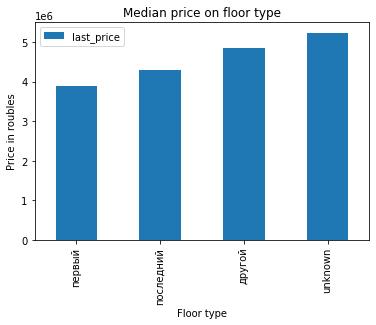

In [115]:
# зависимость медианной стоимости от типа этажа
(
    df
    .pivot_table(index='floor_type', values='last_price', aggfunc='median')
    .sort_values('last_price')
    .plot(y='last_price', 
          kind='bar',
          title='Median price on floor type',
          xlabel='Floor type',
          ylabel='Price in roubles'
         )
)

Стоимость квартиры не зависит от конкретного этажа, на котором она расположена, но есть зависимость от типа этого этажа. Квартиры на первом и последнем этажах стоят несколько ниже, чем на других этажах, вероятно это связано с тем, что при покупке многие не хотят квартиры на первом этаже из-за сниженной безопасности, а на последнем из-за возможных проблем с крышей.

#### Зависимость стоимости от даты размещения объявления

<AxesSubplot:title={'center':'Price on publication day of week'}, xlabel='Day of the week', ylabel='Price in roubles'>

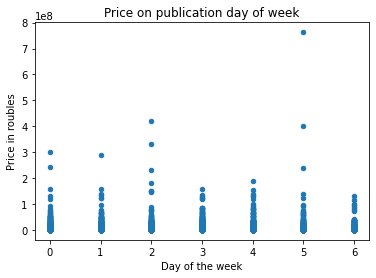

In [116]:
# стоимость квартиры в зависимости от дня размещения объявления
df.plot(x='day_of_week', 
        y='last_price', 
        kind='scatter',
        title='Price on publication day of week',
        xlabel='Day of the week',
        ylabel='Price in roubles'
       ) 

<AxesSubplot:title={'center':'Median price on day of week'}, xlabel='Day of the week', ylabel='Price in roubles'>

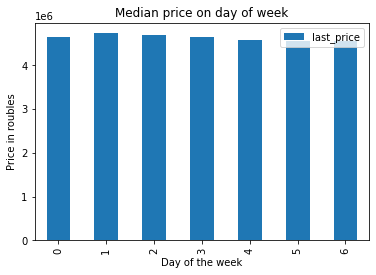

In [117]:
# медианная стоимость квартиры в зависимости от дня размещения объявления
(
    df
    .pivot_table(index='day_of_week', values='last_price', aggfunc='median')
    .sort_values('day_of_week')
    .plot(y='last_price', 
          kind='bar',
          title='Median price on day of week',
          xlabel='Day of the week',
          ylabel='Price in roubles'
         )
)

Ожидаемо никакой зависимости стоимости квартиры от дня недели, в который разместили объявление, нет.

<AxesSubplot:title={'center':'Median price on day of the week'}, xlabel='Day of the week', ylabel='Price'>

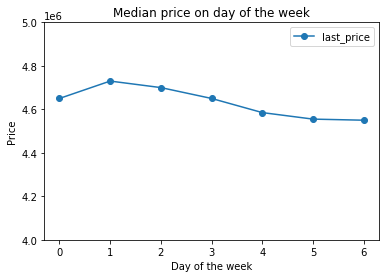

In [118]:
# медианная стоимость квартиры в зависимости от дня размещения объявления
(
    df
    .pivot_table(index='day_of_week', values='last_price', aggfunc='median')
    .sort_values('day_of_week')
    .plot(y='last_price', 
          style='o-', 
          ylim=(4000000, 5000000), 
          title='Median price on day of the week',
          xlabel='Day of the week',
          ylabel='Price'
         )
)

<div class="alert alert-info"> 
    Добавил линейный график, заметно, что к концу недели стоимость немного снижается, но видимо это связано со снижением количества объявлений в эти дни.

<AxesSubplot:title={'center':'Price on month'}, xlabel='Month', ylabel='Price in roubles'>

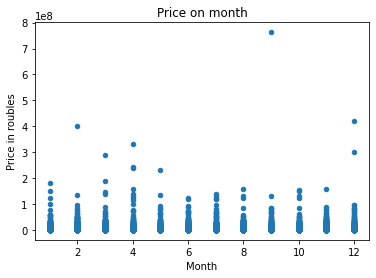

In [119]:
# стоимость квартиры в зависимости от месяца размещения объявления

df.plot(x='month', 
        y='last_price', 
        kind='scatter', 
        title='Price on month',
        xlabel='Month',
        ylabel='Price in roubles'
       )

<AxesSubplot:title={'center':'Median price on month'}, xlabel='Month', ylabel='Price in roubles'>

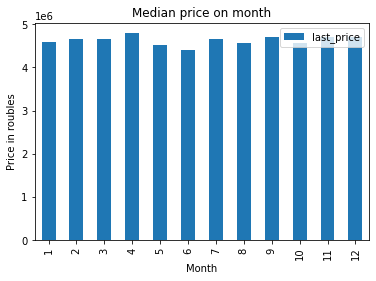

In [120]:
# медианная стоимость квартиры в зависимости от месяца размещения объявления

(
    df
    .pivot_table(index='month', values='last_price', aggfunc='median')
    .sort_values('month')
    .plot(y='last_price', 
          kind='bar',
          title='Median price on month',
          xlabel='Month',
          ylabel='Price in roubles'
         )
)

Стоимость квартиры не зависит от месяца, в который размещалось объявление, так же как и от дня недели.

<AxesSubplot:title={'center':'Price on month'}, xlabel='Month', ylabel='Price in roubles'>

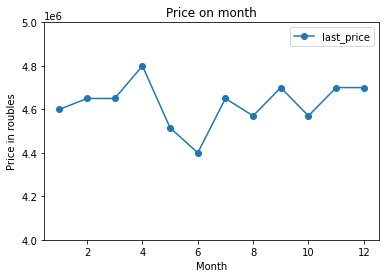

In [121]:
# медианная стоимость квартиры в зависимости от дня размещения объявления
(
    df
    .pivot_table(index='month', values='last_price', aggfunc='median')
    .sort_values('month')
    .plot(y='last_price', 
          style='o-', 
          ylim=(4000000, 5000000), 
          title='Price on month',
          xlabel='Month',
          ylabel='Price in roubles'
         )
)

<div class="alert alert-info">  Видно, что в мае и июне стоимость ниже, но сложно предположить с чем это связано.

<AxesSubplot:title={'center':'Price on year'}, xlabel='Year', ylabel='Price in roubles'>

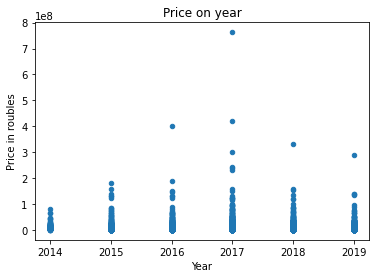

In [122]:
# стоимость квартиры в зависимости от года размещения объявления

df.plot(x='year', 
        y='last_price', 
        kind='scatter',
        title='Price on year',
        xlabel='Year',
        ylabel='Price in roubles'
       )

<AxesSubplot:title={'center':'Median price on year'}, xlabel='Year', ylabel='Price in roubles'>

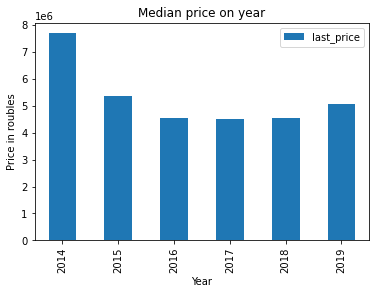

In [123]:
# медианная стоимость квартиры в зависимости от года размещения объявления

(
    df
    .pivot_table(index='year', values='last_price', aggfunc='median')
    .sort_values('year')
    .plot(y='last_price', 
          kind='bar',
          title='Median price on year',
          xlabel='Year',
          ylabel='Price in roubles'
         )
)

In [124]:
# медиана стоимости в зависимости от года и количество объявлений в кажом году
(
    df
    .pivot_table(index='year', values='last_price', aggfunc=['median','count'])
)

,median,count
,last_price,last_price
year,,
2014,7700000.0,137
2015,5350000.0,1191
2016,4550000.0,2783
2017,4500000.0,8190
2018,4550000.0,8519
2019,5050000.0,2879


Можно заметить, что в 2014 году медианная стоимость квартир была выше, возможно это связно с тем, что выборка для 2014 года существенно ниже - всего 137 объявлений. Другая причина - возможно после кризиса 2014 года стоимость квартир упала, в 2015 году также падала, далее уже до 2019 года держалась на примерно одном уровне, а в 2019 году наметился рост цены.

#### Стоимость одного квадратного метра квартиры

<AxesSubplot:title={'center':'Mean cost per square metres'}, xlabel='Locality name', ylabel='Cost per square metres in roubles'>

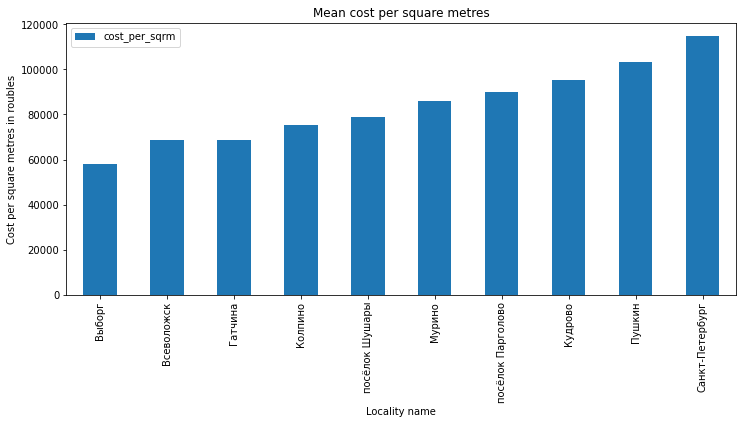

In [125]:
# стоимость одного кв.м. квартиры для 10 регионов, с наибольшим количеством объявлений
(
    df
    .query('locality_name == @top_10')
    .pivot_table(index='locality_name', values='cost_per_sqrm')
    .sort_values('cost_per_sqrm')
    .plot(kind='bar', 
          figsize=(12, 5),
          title='Mean cost per square metres',
          xlabel='Locality name',
          ylabel='Cost per square metres in roubles'
         )
)

В Санкт-Петербурге стоимость квадратного метра квартиры в среднем выше, чем в остальных населенных пунктах, это главный центр региона и крупный город, поэтому стоимость выше. Ближайшие по стоимости к Санкт-Петербургу - это города-спутники, находящиеся в непосредственной близости к Санкт-Петербургу, поэтому стоимость квадратного метра у них также высокая. Наименьшая стоимость из населенных пунктов, где больше всего объявлений, в городе Выборге, именно он находится максимально далеко от Санкт-Петербурга из населенных пунктов в `top_10`.

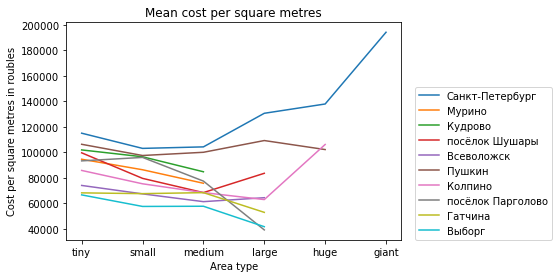

In [126]:
for name in top_10:
     plt.plot(
         df.query('locality_name == @name')
         .groupby('area_type')
         .agg({'cost_per_sqrm': 'median'})
         .sort_values('area_type', ascending=False)
)
plt.legend(top_10, loc=(1.04, 0))
plt.title('Mean cost per square metres')
plt.xlabel('Area type')
plt.ylabel('Cost per square metres in roubles')
plt.show()

Для самых маленьких квартир стоимость квадратного метра выше. Для квартир средних размеров стоимость квадратного метра уменьшается с увеличением площади, но уже для больших квартир вырастает, скорее всего из-за того, что такие квартиры уже являются не типовыми.

#### Стоимость километров от центра для Санкт-Петербурга

In [127]:
# расчет стоимости одного километра от центра Санкт-Петербурга
df.loc[df['locality_name'] == 'Санкт-Петербург', 'cost_per_1km'] = \
df.loc[df['locality_name'] == 'Санкт-Петербург', 'last_price'] \
/ df.loc[(df['locality_name'] == 'Санкт-Петербург') & (df['cityCenters_nearest_km'] != 0), 'cityCenters_nearest_km']

<AxesSubplot:title={'center':'Mean cost of each km from the center of St. Petersburg'}, xlabel='Kilometres from the center', ylabel='Cost in roubles'>

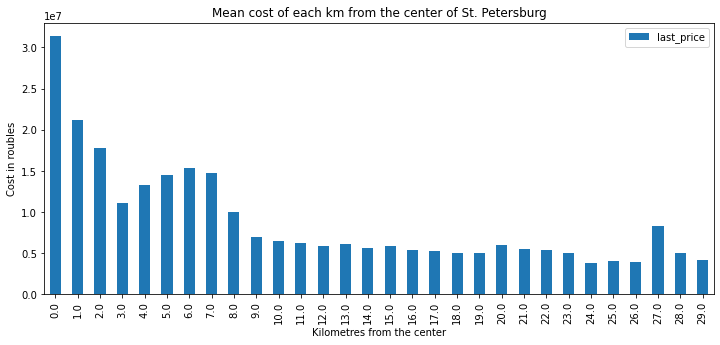

In [128]:
# средняя стоимость каждого километра от центра Санкт-Петербурга
(
    df
    .query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')
    .plot(kind='bar', 
          figsize=(12, 5),
          title='Mean cost of each km from the center of St. Petersburg',
          xlabel='Kilometres from the center',
          ylabel='Cost in roubles'
         )
)

In [129]:
df[(df['cityCenters_nearest_km'] == 27) & (df['locality_name'] == 'Санкт-Петербург')]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,living_to_total_area_ratio,kitchen_to_total_minus_living_area_ratio,cost_per_sqrm,day_of_week,month,year,floor_type,cityCenters_nearest_km,timedelta,cost_per_1km
748,13,14350000.0,74.0,2017-11-28,2,3.13,5.0,30.0,3,NaN,...,0.405405,0.568182,193918.918919,1,11,2017,другой,27.0,521 days,531481.481481
5961,6,2250000.0,32.0,2018-02-27,1,2.70,2.0,16.5,2,NaN,...,0.515625,0.451613,70312.500000,1,2,2018,последний,27.0,430 days,83333.333333


Ожидаемо, самая высокая цена у квартир, которые находятся ближе к центру. Повышение стоимости для 4-6 километров связано скорее всего с тем, что квартиры находятся в дорогих районах - Петроградский, Крестовский остров. При дальнейшем удалении от центра стоимость квартир уже не сильно меняется. Локальный максимум для 27 км связан с тем, что всего 2 объявления попадают под эти условия и одно из них с высокой ценой.

<AxesSubplot:title={'center':'Mean cost per 1 km from the center of St. Petersburg'}, xlabel='Kilometres', ylabel='Cost in roubles'>

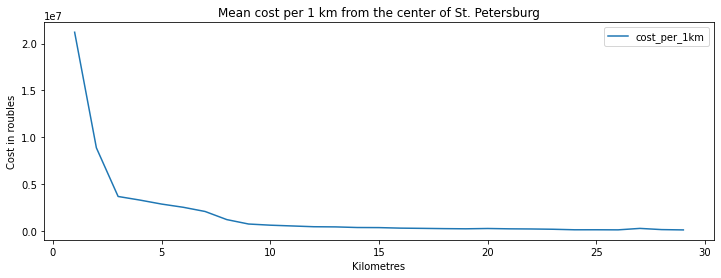

In [130]:
# усредненная стоимость 1 километра от центра для Санкт-Петербурга
(
    df.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest_km', values='cost_per_1km')
    .plot(figsize=(12, 4),
          title='Mean cost per 1 km from the center of St. Petersburg',
          xlabel='Kilometres',
          ylabel='Cost in roubles'
         )
)

На данном графике более наглядно видно, что при удалении от центра на более, чем 10 километров, стоимость каждого из этих километров остается примерно одинаковой. При приближении к центру она возрастает

<div class="alert alert-info"> 
   <ul><li>На данном этапе были исследованы следующие параметры:
    <ul><li>общая площадь</li>
        <li>жилая площадь</li>
        <li>площадь кухни</li>
        <li>цена объекта</li>
        <li>количество комнат</li>
        <li>высота потолков</li>
        <li>этаж квартиры</li>
        <li>тип этажа квартиры</li>
        <li>общее количество этажей в доме</li>
        <li>расстояние до центра города</li>
        <li>расстояние до ближайшего аэропорта</li>
        <li>расстояние до ближайшего парка</li>
        <li>день и месяц публикации объявления</li>
       </ul></li>
    <li>Изучено как быстро продавались квартиры и как зависит цена от общей площади, жилой площади, площади кухни, количества комнат, этажа, на котором расположена квартира и даты размещения.</li>
    <li>Посчитана средняя цена одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений </li>
        <li>Посчитана средння цена каждого километра удаления от центра города для Санкт-Петербурга. </li></ul>



### Общий вывод

#### Общая площадь квартир, жилая площадь и площадь кухни

* Наибольшее количество объявлений по квартирам общей площадью от 30 до 50 квадратных метров. В основном это одно-двухкомнатные квартиры, которые чаще строились. Большое количество таких объявлений и объясняется тем, что таких квартир в принципе больше.
* Жилая площадь сильно зависит от общей площади квартиры, поэтому большинство объявлений с жилой площадью от 15 до 30 квадратных метров, что соответствует квартирам общей площадью от 30 до 50 кв.м.
* Большинство объявлений с площадью кухни от 7 до 12 квадратных метров, это также соответствует типичным одно-двухккомнатным квартирам. С увеличением площади кухни количество объявлений сильно уменьшается, т.к. даже для больших по площади квартир кухня все равно не становится сильно больше.

#### Стоимость квартир

Наибольшее количество квартир стоимостью 2.5 - 5.0 млн. руб., что также соответствует квартирам общей площадью от 30 до 50 кв. м.

#### Количество комнат в квартирах

Большинство квартир - однокомнатные или двухкомнатные, количество объявлений о продаже квартир с бóльшим количеством комнат уменьшается с увеличением комнат.

#### Высота потолков в квартирах

Наибольшее количество квартир с потолками высотой 2.6 - 3.0 метра, это типичная высота потолков для большинства квартир.

#### Этажность

* Большинство квартир находится на этажах с первого по пятый, начиная с шестого этажа заметно резкое снижение количества объявлений, это связано с тем, что большое количество домов - пятиэтажные.
* Это подтверждают и данные по общему количеству этажей в доме. Большинство объявлений о квартирах в пятиэтажных домах, также достаточно много объявлений в 9-, 12- и 16-этажных домах - это наиболее распространенные типы домов.
* Меньше объявлений о квартирах на первом и последнем этаже, это естественно, т.к. таких этажей меньше (для одного дома есть только один первый и один последний этажи, а других может быть существенно больше в зависимости от общей этажности дома)

#### Расстояния до центра населенного пункта, ближайшего аэропорта и парка

* Наибольшее количество объявлений о продаже квартир на расстоянии от 6 до 20 километров от центра города, т.к. это наиболее распространенные размеры населенных пунктов. Квартир ближе к центру меньше, потому что радиус в 6 км от центра вмещает в себя меньше домов, чем радиус 20 км, соответственно и квартир будет меньше.
* От аэропорта большинство квартир находится на расстоянии 15-35 км, т.к. это типичное расположение аэропортов - на некотором удалении от города.
* Так как при обустройстве городов планируются парки, то большинство квартир имеет хотя бы один парк в радиусе одного километра.

#### Дни и месяцы размещения объявлений

* В выходные дни размещается примерно в 2 раза больше объявлений, чем в любой будний день. Скорее всего люди не хотят заниматься какими-то делами в выходные дни, поэтому размещают объявления в основном в рабочие дни. 
* В целом количество объявлений не зависит от месяца, но есть несколько заметных спадов. Меньше всего подают объявления в январе, мае и декабре. Вероятно это связано с большим количеством праздничных дней в январе и мае, а в декабре с подготовкой к Новому Году.

#### Продолжительность размещения объявлений

* В среднем объявление о продаже квартиры остается активным 180 дней, но это значение сильно искажено из-за наличия объявлений, которые не убирают в течение нескольких лет.
* Если взять медиану и тем самым уменьшить влияние слишком продолжительных продаж, то получим значение в 95 дней, что скорее всего больше соответствует реальности.
* Быстрыми можно считать продаже за менее чем 45 дней, долгими - продажи за более чем 232 дня.
* Имеется большое количество слишком долгих продаж, что связано скорее всего с тем, что объявления просто не убирали.

#### Зависимость стоимости квартиры от общей площади, жилой площади и площади кухни

* Стоимость квартиры положительно зависит от ее площади. Коэффициент корреляции Пирсона равен 0.65, что говорит о средней зависимости. Это связано с тем, что есть еще дополнительные факторы, которые влияют на стоимость. Если построить график зависимости стоимости от общей площади с учетом медианных значений по разным типам квартир (в зависимости от площади), то видно, что зависимость есть, но она не линейна.
* Так как жилая площадь квартиры сильно зависит от ее общей площади (коэффициент корреляции 0.95), то стоимость квартиры зависит от жилой площади схожим образом.
* От площади кухни стоимость квартиры слабо зависит, другие факторы оказывают влияние более сильное.

#### Зависимость стоимости квартиры от этажности

* Никакой зависимости стоимости квартиры от ее этажа выявлено не было.
* Имеется зависимост от типа этажа: квартиры на первом и последнем этажах дешевле, скорее всего потому что на первом этажа ниже безопасность, а на последнем могут возникать проблемы с крышей.

#### Зависимость стоимости квартиры от даты размещения объявления

* Зависимости стоимости квартиры от дня недели, в который было размещено объявление, обнаружено не было.
* От месяца, в который было опубликовано объявление, стоимость квартиры также не зависит.
* Медианная стоимость квартир в 2014 году выше, чем в последующие, возможно это связано с кризисом 2014 года и последующим удешевлением квартир. В 2019 году стоимость начала подниматься.

#### Зависимость стоимости одного квадратного метра квартиры от населенного пункта

В данном исследовании рассматривали только 10 населенных пунктов, в которых наибольшее количество объявлений о продаже квартир.
* Стоимость квадратного метра в Санкт-Петербурге в среднем выше, чем в остальных населенных пунктах. Это объясняется тем, что Санкт-Петербург - центр региона и крупный город с большим населением.
* Ближайшие по средней стоимости квадратного метра к Санкт-Петербургу оказались его города-спутники, наиболее близкорасположенные, этим и объясняется их высокая стоимость.
* Наименьшая стоимость квадратного метра в Выборге, он как раз является самым удаленным городом от Санкт-Петербурга из представленных.

#### Стоимость километра удаления от центра для Санкт-Петербурга

* Самая высокая цена у квартир, которые находятся ближе к центру.
* Также несколько увеличивается стоимость квартир на удалении в 4-6 километров от центра, вероятно это квартиры в традиционно дорогих районах города - Петроградском и Крестовском.
* В среднем стоимость одного километра удаления от центра падает до 10 км, при дальнейшем удалении остается почти неизменной.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод